# Introduction

Last updated: 2024-10-07 (A.L.)

Using the `helseveileder` kernel for this notebook.

### Hypotesene som undersøkes er følgende:

**Kunnskapsnivå** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål på _samme_ kunnskapsnivå, sammenlignet svar fra utdannede og lisensierte leger (MDs).<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _forskjellig_ kunnskapsnivå sammenlignet med leger (trolig _lavere_ kunnskapsnivå).

**Empati** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _samme_ grad av empati, sammenlignet med svar fra leger.<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _ulik_ grad av empati sammenlignet med leger (trolig _mindre_ grad av empati).

**Hjelpsomhet** :<br>
H0: Chat-GPT 4.0 genererer _samme_ grad av hjelpsomme svar på kliniske spørsmål, sammenlignet med leger.<br>
H1: Chat-GPT 4.0 genererer _forskjellig_ grad av hjelpsomme svar på kliniske spørsmål sammenlignet med leger (trolig _mindre_ hjelpsomhet).

**Respondent kategori** :<br>
H0: leger og medisinstudenter med lisens vurderer Chat-GPT 4.0 sine svar på kliniske spørsmål som _like_ kunnskapsrike som hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør i vurderingen av Chat-GPT 4.0 sine svar mhp. kunnskap.<br>
H1: leger og medisinstudenter med lisens vurderer Chat-GPT 4.0 sine svar på kliniske spørsmå til å ha _ulik_ grad av kunnskap sammenliknet med hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør.

**Mann-Whitney U test**: non-parametric test of the null hypothesis that two populations are the same against an alternative hypothesis, especially that a particular population tends to have larger values than the other.

# Setup

In [1]:
%matplotlib inline
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu 

In [2]:
DATA = Path.cwd()/'..'/'data'
RESULTS = Path.cwd()/'..'/'results'

# Get home directory
HOME = os.getenv('HOME')

# Get user
import getpass
USER = getpass.getuser()


# Load data

In [3]:
latest_date = '310124-190224' # from 2024-02-22 and onwards

In [4]:
df = pd.read_csv(f'{DATA}/merged_data-{latest_date}.csv')
len(df)

2304

In [5]:
list(df.columns)

['vurderingid',
 'respondentid',
 'svarid',
 'kunnskap',
 'empati',
 'hjelpsomhet',
 'alder',
 'utdanningsgrad',
 'helsepersonell',
 'harlisens',
 'kjønn',
 'svartfør',
 'fylke',
 'dato',
 'spørsmålid',
 'chatgpt',
 'svartekst',
 'tekst']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   vurderingid     2304 non-null   int64 
 1   respondentid    2304 non-null   int64 
 2   svarid          2304 non-null   int64 
 3   kunnskap        2304 non-null   int64 
 4   empati          2304 non-null   int64 
 5   hjelpsomhet     2304 non-null   int64 
 6   alder           2276 non-null   object
 7   utdanningsgrad  2304 non-null   object
 8   helsepersonell  2304 non-null   bool  
 9   harlisens       2304 non-null   bool  
 10  kjønn           2284 non-null   object
 11  svartfør        2304 non-null   bool  
 12  fylke           2302 non-null   object
 13  dato            2304 non-null   object
 14  spørsmålid      2304 non-null   int64 
 15  chatgpt         2304 non-null   bool  
 16  svartekst       2304 non-null   object
 17  tekst           2304 non-null   object
dtypes: bool(

In [7]:
# Make a dataframe dmeta with the metadata (col-number, col-name, data-type, number-of-nans, min, max) of the dataframe df

# Create a list of column numbers
col_numbers = range(len(df.columns)+1)[1:]

# Create a list of column names
col_names = df.columns

# Create a list of column data types
col_dtypes = df.dtypes

# Create a list of column number of NaNs
col_nans = df.isna().sum()

# Create a list of column minimum values excluding NaN
def min_of_each_column(df):
    return df.apply(lambda col: col.dropna().min())
col_min = min_of_each_column(df)

# Create a list of column maximum values
def max_of_each_column(df):
    return df.apply(lambda col: col.dropna().max())
col_max = max_of_each_column(df)

# Create a dataframe dmeta with the metadata
dmeta = pd.DataFrame({'col_number': col_numbers, 'col_name': col_names, 'col_dtype': col_dtypes, 'col_nans': col_nans, 'col_min': col_min, 'col_max': col_max})

# Reset the index of the dataframe dmeta
dmeta.reset_index(drop=True, inplace=True)

# Display the dataframe dmeta
dmeta

,col_number,col_name,col_dtype,col_nans,col_min,col_max
0,1,vurderingid,int64,0,1,2304
1,2,respondentid,int64,0,3,638
2,3,svarid,int64,0,1,393
3,4,kunnskap,int64,0,0,6
4,5,empati,int64,0,0,5
5,6,hjelpsomhet,int64,0,0,5
6,7,alder,object,28,18-20,71+
7,8,utdanningsgrad,object,0,Bachelor,VGS
8,9,helsepersonell,bool,0,False,True
9,10,harlisens,bool,0,False,True


### Keep responses for which none of the following criteria are met:
```python
 `kunnskap` == 0 or `empati` == 0 or `hjelpsomhet` == 0  
```
i.e., missing values for any of the three criteria.

In [8]:
# Find all rows where `kunnskap` == 0 or `empati` == 0 or `hjelpsomhet` == 0

df0 = df[(df['kunnskap'] == 0) | (df['empati'] == 0) | (df['hjelpsomhet'] == 0)]
print(f'There are {len(df0)} rows where kunnskap, empati, or hjelpsomhet is 0 (out of {len(df)})')

There are 17 rows where kunnskap, empati, or hjelpsomhet is 0 (out of 2304)


In [9]:
# How many rows in df0 has chatgpt==True
num_rows = (df0['chatgpt'] == True).sum()
print(f'There are {num_rows} (out of {len(df)}) rows which has missing criteria and where chatgpt is True \
on "kunnskap", "empati", or "hjelpsomhet"')

num_rows = (df0['chatgpt'] == False).sum()
print(f'There are {num_rows} (out of {len(df)}) rows which has missing criteria and where human is True \
on "kunnskap", "empati", or "hjelpsomhet"')

There are 7 (out of 2304) rows which has missing criteria and where chatgpt is True on "kunnskap", "empati", or "hjelpsomhet"
There are 10 (out of 2304) rows which has missing criteria and where human is True on "kunnskap", "empati", or "hjelpsomhet"


### We are dropping these rows from the dataset:

In [10]:
# Drop these rows

df1 = df[~((df['kunnskap'] == 0) | (df['empati'] == 0) | (df['hjelpsomhet'] == 0))]
len(df1)

2287

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2287 entries, 0 to 2303
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   vurderingid     2287 non-null   int64 
 1   respondentid    2287 non-null   int64 
 2   svarid          2287 non-null   int64 
 3   kunnskap        2287 non-null   int64 
 4   empati          2287 non-null   int64 
 5   hjelpsomhet     2287 non-null   int64 
 6   alder           2259 non-null   object
 7   utdanningsgrad  2287 non-null   object
 8   helsepersonell  2287 non-null   bool  
 9   harlisens       2287 non-null   bool  
 10  kjønn           2267 non-null   object
 11  svartfør        2287 non-null   bool  
 12  fylke           2285 non-null   object
 13  dato            2287 non-null   object
 14  spørsmålid      2287 non-null   int64 
 15  chatgpt         2287 non-null   bool  
 16  svartekst       2287 non-null   object
 17  tekst           2287 non-null   object
dtypes: bool(4), i

len(df_GPT)=1145, len(df_human)=1142


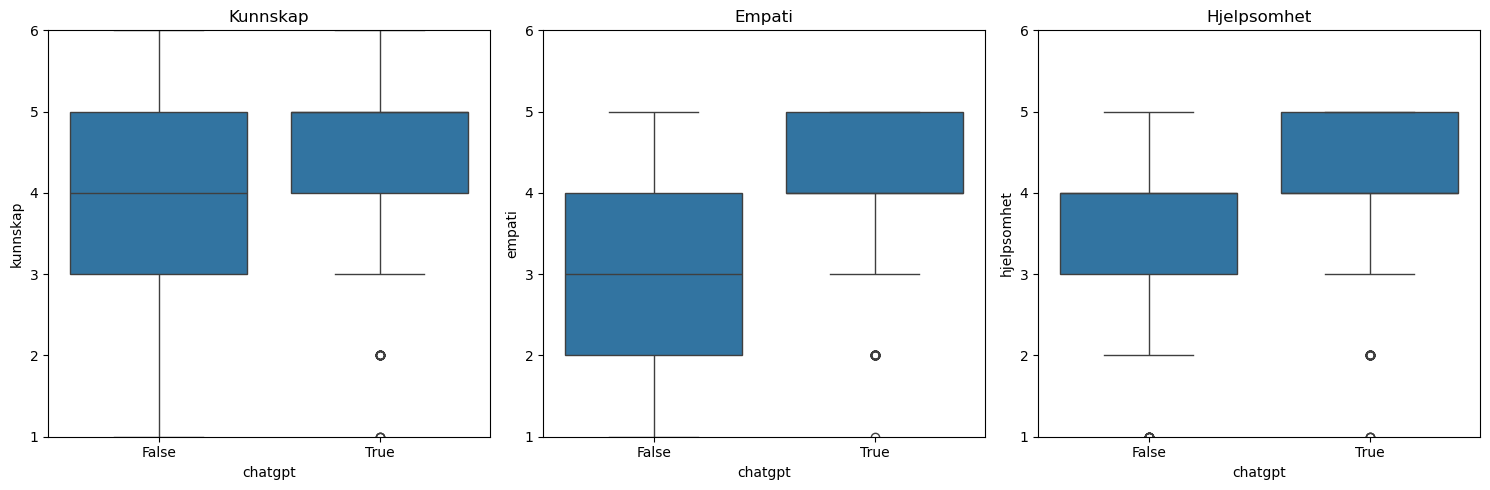

In [12]:
df_GPT = df1[df1['chatgpt'] == True]
df_human = df1[df1['chatgpt'] == False]

print(f'len(df_GPT)={len(df_GPT)}, len(df_human)={len(df_human)}')

# Make a boxplot to compare the GPT and human responses for `kunnskap', 'empati` and 'hjelpsomhet'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='chatgpt', y='kunnskap', data=df1, ax=ax[0])
ax[0].set_title('Kunnskap')

sns.boxplot(x='chatgpt', y='empati', data=df1, ax=ax[1])
ax[1].set_title('Empati')

sns.boxplot(x='chatgpt', y='hjelpsomhet', data=df1, ax=ax[2])
ax[2].set_title('Hjelpsomhet')

for a in ax:
    a.set_ylim(1, 6)
plt.tight_layout()  



### Hypotese 1 som undersøkes (mhp. df1) er følgende:

**Kunnskapsnivå** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål på _samme_ kunnskapsnivå, sammenlignet svar fra utdannede og lisensierte leger (MDs).<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _forskjellig_ kunnskapsnivå sammenlignet med leger (trolig _lavere_ kunnskapsnivå).

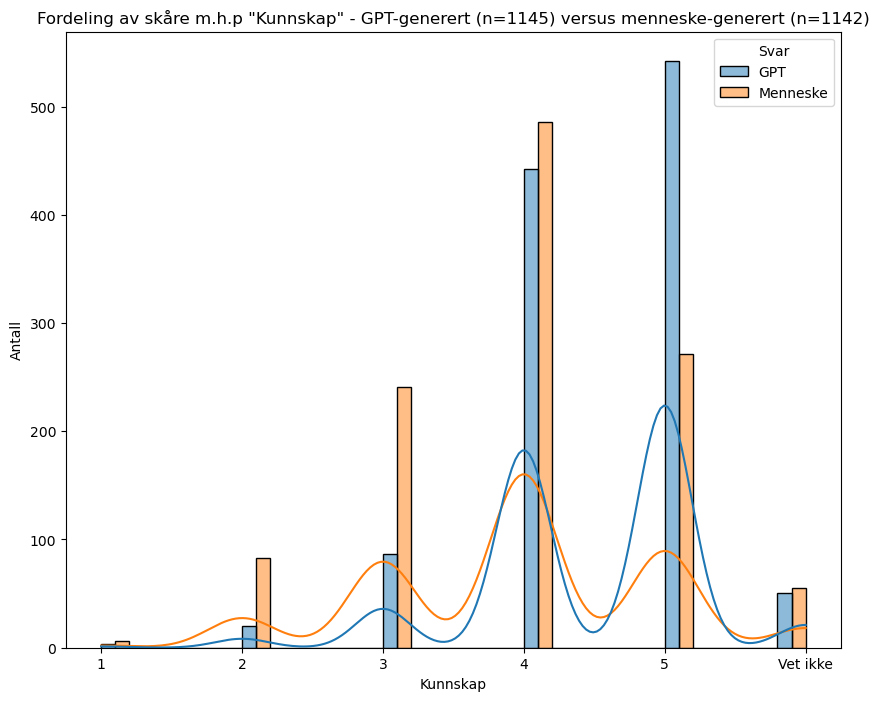

In [13]:
# Plot the distribution of the scores for "kunnskap" - GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['kunnskap']].assign(Svar='GPT'), df_human[['kunnskap']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='kunnskap', hue='Svar', multiple='dodge', kde=True, binwidth=0.2)

plt.xlabel('Kunnskap')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Kunnskap" - GPT-generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(6)

# Replace the label at the index with 'Vet ikke'
labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels


plt.show()

In [14]:
# Make new dataframes df_GPT_kunsskap_excl6 and df_human_kunnskap_excl6 where kunnskap is not 6

df_GPT_kunnskap_excl6 = df_GPT[df_GPT['kunnskap'] != 6]
df_human_kunnskap_excl6 = df_human[df_human['kunnskap'] != 6]

print(f'len(df_GPT_kunnskap_excl6)={len(df_GPT_kunnskap_excl6)}, len(df_human_kunnskap_excl6)={len(df_human_kunnskap_excl6)}')


len(df_GPT_kunnskap_excl6)=1094, len(df_human_kunnskap_excl6)=1087


stat=788164.5, p=2.4010337081210183e-45
Forskjellig fordeling (forkast H0)
($n_{GPT}$ = 1094, $n_{human}$ = 1087)


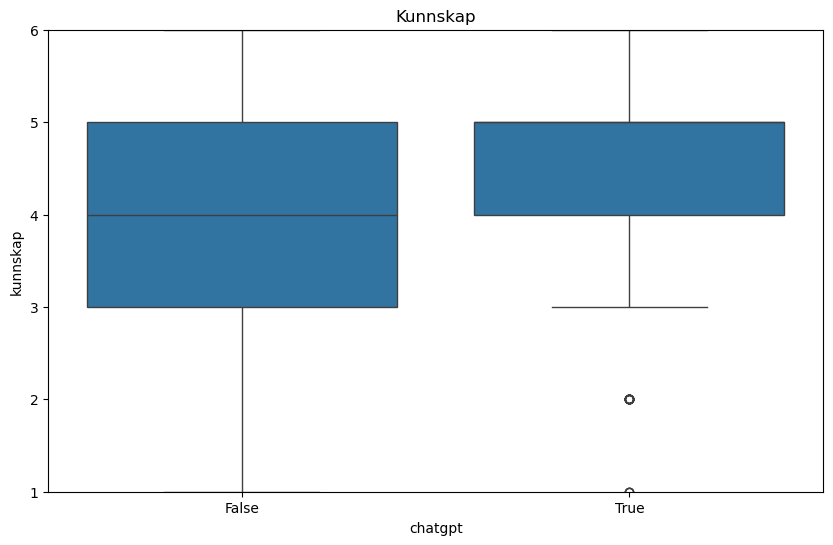

In [15]:
# Test the following hypothesis: H0: The distribution of the scores for kunnskap for GPT and human are the same 
# vs. H1: The distribution of the scores of kunnskap for GPT and human are different (human scores are likely higher)

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(df_GPT_kunnskap_excl6['kunnskap'], df_human_kunnskap_excl6['kunnskap'])
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT}}$ = {len(df_GPT_kunnskap_excl6)}, $n_{{human}}$ = {len(df_human_kunnskap_excl6)})')

# Make a boxplot to compare the GPT and human responses for `kunnskap`

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='chatgpt', y='kunnskap', data=df1, ax=ax)
ax.set_title('Kunnskap')
ax.set_ylim(1, 6)
plt.show()


In [16]:
# Test the following hypothesis: H0: The distribution of the scores for kunnskap for GPT and human are the same 
# vs. H1: The distribution of the scores of kunnskap for GPT and human are different (human scores are likely higher)

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(df_GPT_kunnskap_excl6['kunnskap'], df_human_kunnskap_excl6['kunnskap'])
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT}}$ = {len(df_GPT_kunnskap_excl6)}, $n_{{human}}$ = {len(df_human_kunnskap_excl6)})')

stat=788164.5, p=2.4010337081210183e-45
Forskjellig fordeling (forkast H0)
($n_{GPT}$ = 1094, $n_{human}$ = 1087)


The Mann-Whitney U test is a non-parametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

Mathematically, the Mann-Whitney U test works as follows:

1. Combine all the values from the two samples into one set and sort them in ascending order.
2. Assign ranks to these values. The smallest value gets a rank of 1, the second smallest a rank of 2, and so on. In case of ties, assign to each tied value the average of the ranks they would have received if they were not tied.
3. Sum the ranks for the values from each of the two samples separately. Let's call these sums R1 and R2.
4. Calculate U for each sample using the formula U = n1*n2 + n*(n+1)/2 - R, where n is the size of the sample and R is the sum of the ranks in that sample. There will be two U values, U1 and U2.
5. The smaller of U1 and U2 is the Mann-Whitney U statistic.

The null hypothesis (H0) for the test is that the distributions of both populations are equal. If the p-value is less than the chosen significance level (typically 0.05), the null hypothesis is rejected and it can be concluded that there is a significant difference between the two populations.

In Python, you can use the `mannwhitneyu` function from the `scipy.stats` module to perform the Mann-Whitney U test. This function returns two values: the U statistic and the p-value. Here's an example of how to interpret the results:

In [17]:
from scipy.stats import mannwhitneyu

# Assuming 'sample1' and 'sample2' are your two samples
sample1, sample2 = df_GPT['kunnskap'], df_human['kunnskap']

# Perform the Mann-Whitney U test
U, p = mannwhitneyu(sample1, sample2)

print('U statistic:', U)
print('p-value:', p)

U statistic: 845004.0
p-value: 6.506206828684302e-38


The Mann-Whitney U test, also known as the Wilcoxon rank-sum test, is a non-parametric test that compares two unpaired groups of data. It's used to determine whether there is a significant difference between the two groups. It's a non-parametric alternative to the independent t-test and can be used when the assumption of normality is not met.

Here's how it works:

1. **Ranking**: Combine all values from both groups into a single set and rank them in ascending order. If there are ties (equal values), assign each a rank equal to the average of the ranks they would have occupied if they were not tied.

2. **Sum of Ranks**: Calculate the sum of the ranks for each group separately.

3. **U Statistic**: Calculate the U statistic for each group. The U statistic for a group is the sum of the ranks in that group minus the theoretical minimum this sum could have (which is `(n*(n+1))/2` where `n` is the size of the group). The smaller U statistic of the two is the one used for the test.

4. **Significance**: Compare the calculated U statistic to a critical value from the U distribution (which is tabulated and depends on the sizes of the two groups). If the calculated U is less than or equal to the critical value, the null hypothesis (that the two groups are samples from populations with the same distribution) can be rejected.

In Python, you can use the `mannwhitneyu` function from the `scipy.stats` module to perform the Mann-Whitney U test. This function returns two values: the U statistic and the p-value (which is calculated using an approximation that is valid for large sample sizes). If the p-value is less than the chosen significance level (typically 0.05), the null hypothesis is rejected.

In [18]:
# How large is the difference in the median scores of "kunnskap" for GPT and human (excluding "Vet ikke")?

median_GPT = df_GPT_kunnskap_excl6['kunnskap'].median()
median_human = df_human_kunnskap_excl6['kunnskap'].median()
diff = median_GPT - median_human
print(f'Median score for kunnskap for GPT: {median_GPT} (excluding "Vet ikke")')
print(f'Median score for kunnskap for human: {median_human} (excluding "Vet ikke")')
print(f'Difference in median scores: {diff}')

Median score for kunnskap for GPT: 4.0 (excluding "Vet ikke")
Median score for kunnskap for human: 4.0 (excluding "Vet ikke")
Difference in median scores: 0.0


In [19]:
# How large is the difference in the mean scores of kunnskap for GPT and human?

mean_GPT = df_GPT_kunnskap_excl6['kunnskap'].mean()
mean_human = df_human_kunnskap_excl6['kunnskap'].mean()

std_GPT = df_GPT['kunnskap'].std()
std_human = df_human['kunnskap'].std()

diff = mean_GPT - mean_human
print(f'Mean score for kunnskap for GPT: {mean_GPT:.2f} ± {std_GPT:.2f} (n={len(df_GPT_kunnskap_excl6)}) (excluding "Vet ikke")')
print(f'Mean score for kunnskap for human: {mean_human:.2f} ± {std_human:.2f} (n={len(df_human_kunnskap_excl6)}) (excluding "Vet ikke")')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for kunnskap for GPT: 4.37 ± 0.79 (n=1094) (excluding "Vet ikke")
Mean score for kunnskap for human: 3.86 ± 0.99 (n=1087) (excluding "Vet ikke")
Difference in mean scores: 0.51


### Hypotese 2 som undersøkes (mhp. df1) er følgende:

**Empati** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _samme_ grad av empati, sammenlignet med svar fra leger.<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _ulik_ grad av empati sammenlignet med leger (trolig _mindre_ grad av empati).

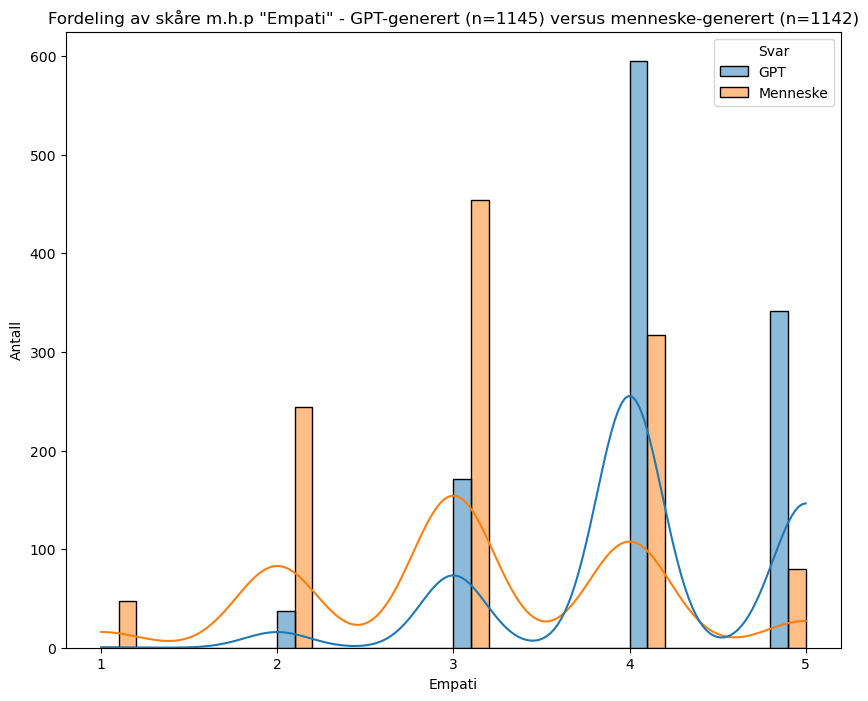

In [20]:
# Plot the distribution of the scores for "empati" -  GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['empati']].assign(Svar='GPT'), df_human[['empati']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='empati', hue='Svar', multiple='dodge', kde=True, binwidth=0.2)

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

plt.xlabel('Empati')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Empati" - GPT-generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')


plt.show()

In [21]:
# Test the following hypothesis: H0: The distribution of the scores for empati for GPT and human are the same 
# vs. H1: The distribution of the scores for empati for GPT and human are different (human scores are likely higher)

from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(df_GPT['empati'], df_human['empati'])
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT}}$ = {len(df_GPT)}, $n_{{human}}$ = {len(df_human)})')

stat=1008219.0, p=1.107670891790499e-122
Forskjellig fordeling (forkast H0)
($n_{GPT}$ = 1145, $n_{human}$ = 1142)


In [22]:
# How large is the difference in the median scores of empati for GPT and human?

median_GPT = df_GPT['empati'].median()
median_human = df_human['empati'].median()
diff = median_GPT - median_human
print(f'Median score for empati for GPT: {median_GPT}')
print(f'Median score for empati for human: {median_human}')
print(f'Difference in median scores: {diff}')

Median score for empati for GPT: 4.0
Median score for empati for human: 3.0
Difference in median scores: 1.0


In [23]:
# How large is the difference in the mean scores of empati for GPT and human?

mean_GPT = df_GPT['empati'].mean()
mean_human = df_human['empati'].mean()

std_GPT = df_GPT['empati'].std()
std_human = df_human['empati'].std()

diff = mean_GPT - mean_human
print(f'Mean score for empati for GPT: {mean_GPT:.2f} ± {std_GPT:.2f} (n={len(df_GPT)})')
print(f'Mean score for empati for human: {mean_human:.2f} ± {std_human:.2f} (n={len(df_human)})')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for empati for GPT: 4.08 ± 0.76 (n=1145)
Mean score for empati for human: 3.12 ± 0.96 (n=1142)
Difference in mean scores: 0.96


### Hypotese 3 som undersøkes (mhp. df1) er følgende:

**Hjelpsomhet** :<br>
H0: Chat-GPT 4.0 genererer _samme_ grad av hjelpsomme svar på kliniske spørsmål, sammenlignet med leger.<br>
H1: Chat-GPT 4.0 genererer _forskjellig_ grad av hjelpsomme svar på kliniske spørsmål sammenlignet med leger (trolig _mindre_ hjelpsomme).

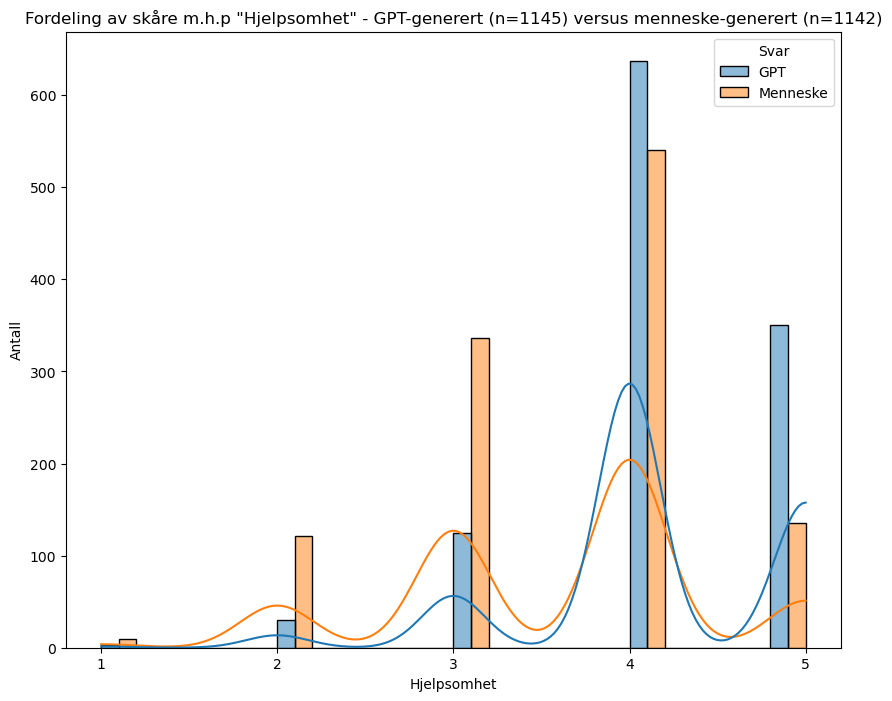

In [24]:
# Plot the distribution of the scores for "hjelpsomhet" -  GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['hjelpsomhet']].assign(Svar='GPT'), df_human[['hjelpsomhet']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='hjelpsomhet', hue='Svar', multiple='dodge', kde=True, binwidth=0.2)

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

plt.xlabel('Hjelpsomhet')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Hjelpsomhet" - GPT-generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')


plt.show()

In [25]:
# Test the following hypothesis: H0: The distribution of the scores for hjelpsomhet for GPT and human are the same 
# vs. H1: The distribution of the scores for hjelpsomhet for GPT and human are different (human scores are likely higher)

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(df_GPT['hjelpsomhet'], df_human['hjelpsomhet'])
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT}}$ = {len(df_GPT)}, $n_{{human}}$ = {len(df_human)})')

stat=885049.0, p=4.1654122032898306e-57
Forskjellig fordeling (forkast H0)
($n_{GPT}$ = 1145, $n_{human}$ = 1142)


In [26]:
# How large is the difference in the median scores of hjelpsomhet for GPT and human?

median_GPT = df_GPT['hjelpsomhet'].median()
median_human = df_human['hjelpsomhet'].median()
diff = median_GPT - median_human
print(f'Median score for hjelpsomhet for GPT: {median_GPT}')
print(f'Median score for hjelpsomhet for human: {median_human}')
print(f'Difference in median scores: {diff}')

Median score for hjelpsomhet for GPT: 4.0
Median score for hjelpsomhet for human: 4.0
Difference in median scores: 0.0


In [27]:
# How large is the difference in the mean scores of hjelpsomhet for GPT and human?

mean_GPT = df_GPT['hjelpsomhet'].mean()
mean_human = df_human['hjelpsomhet'].mean()

std_GPT = df_GPT['hjelpsomhet'].std()
std_human = df_human['hjelpsomhet'].std()

diff = mean_GPT - mean_human
print(f'Mean score for hjelpsomhet for GPT: {mean_GPT:.2f} ± {std_GPT:.2f} (n={len(df_GPT)})')
print(f'Mean score for hjelpsomhet for human: {mean_human:.2f} ± {std_human:.2f} (n={len(df_human)})')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for hjelpsomhet for GPT: 4.14 ± 0.72 (n=1145)
Mean score for hjelpsomhet for human: 3.59 ± 0.86 (n=1142)
Difference in mean scores: 0.55


### Hypotese 4 som undersøkes (mhp. df1) er følgende:

**Respondent kategori** :<br>
H0: leger og medisinstudenter med lisens vurderer Chat-GPT 4.0 sine svar på kliniske spørsmål som _like_ kunnskapsrike som hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør i vurderingen av Chat-GPT 4.0 sine svar mhp. kunnskap.<br>
H1: leger og medisinstudenter med lisens vurderer Chat-GPT 4.0 sine svar på kliniske spørsmå til å ha _ulik_ grad av kunnskap sammenliknet med hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør.

In [28]:
# df_GPT_MD = df_GPT[df_GPT['helsepersonell'] == True]
# df_GPT_nonMD = df_GPT[df_GPT['helsepersonell'] == False]

df_GPT_MD = df_GPT[df_GPT['harlisens'] == True]
df_GPT_nonMD = df_GPT[df_GPT['harlisens'] == False]

print(f'len(df_GPT_MD)={len(df_GPT_MD)}, len(df_GPT_nonMD)={len(df_GPT_nonMD)}')

len(df_GPT_MD)=170, len(df_GPT_nonMD)=975


In [29]:
# Make new dataframes df_GPT_MD_kunnskap_excl6 and df_GPT_nonMD_kunnskap_excl6 where kunnskap is not 6

df_GPT_MD_kunnskap_excl6 = df_GPT_MD[df_GPT_MD['kunnskap'] != 6]
df_GPT_nonMD_kunnskap_excl6 = df_GPT_nonMD[df_GPT_nonMD['kunnskap'] != 6]

print(f'len(df_GPT_MD_kunnskap_excl6)={len(df_GPT_MD_kunnskap_excl6)}, len(df_GPT_nonMD_kunnskap_excl6)={len(df_GPT_nonMD_kunnskap_excl6)}')    


len(df_GPT_MD_kunnskap_excl6)=169, len(df_GPT_nonMD_kunnskap_excl6)=925


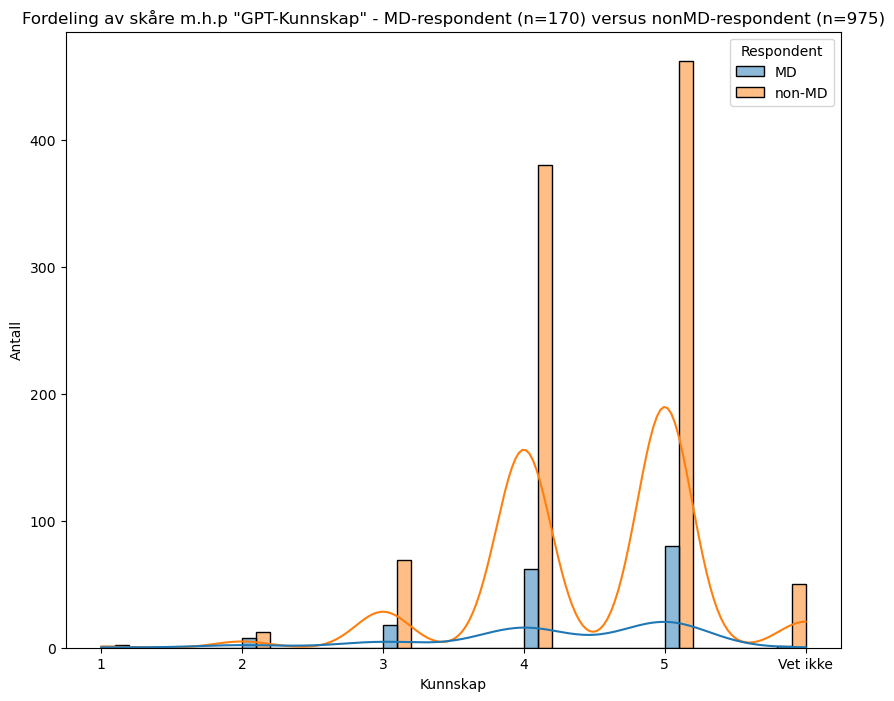

In [31]:
# Plot the distribution of the scores for GPT "kunnskap" -  MD versus nonMD

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT_MD[['kunnskap']].assign(Respondent='MD'), df_GPT_nonMD[['kunnskap']].assign(Respondent='non-MD')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='kunnskap', hue='Respondent', multiple='dodge', kde=True, binwidth=0.2)

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

plt.xlabel('Kunnskap')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "GPT-Kunnskap" - MD-respondent (n={len(df_GPT_MD)}) versus nonMD-respondent (n={len(df_GPT_nonMD)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(6)

# Replace the label at the index with 'Vet ikke'
labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels


plt.show()

In [32]:
# Test the following hypothesis: H0: The distribution of the scores regarding GPT's kunnskap: MD vs. non-MD and are the same 
# vs. H1: The distribution of the scores regarding GPT's kunnskap: MD vs. non-MD and are different (MD's scores are likely lower)

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(df_GPT_MD_kunnskap_excl6['kunnskap'], df_GPT_nonMD_kunnskap_excl6['kunnskap'])
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT_MD}}$ = {len(df_GPT_MD_kunnskap_excl6)}, $n_{{GPT_nonMD}}$ = {len(df_GPT_nonMD_kunnskap_excl6)})')

stat=73384.0, p=0.16033145626526613
Samme fordeling (kan ikke forkaste H0)
($n_{GPT_MD}$ = 169, $n_{GPT_nonMD}$ = 925)


In [33]:
# How large is the difference in the median scores of GPT-kunnskap for MDs vs. non-MDs?

median_MD = df_GPT_MD_kunnskap_excl6['kunnskap'].median()
median_nonMD = df_GPT_nonMD_kunnskap_excl6['kunnskap'].median()
diff = median_MD - median_nonMD
print(f'Median score for GPT-kunnskap for MDs: {median_MD}')
print(f'Median score for GPT-kunnskap for non-MDs: {median_nonMD}')
print(f'Difference in median scores: {diff}')

Median score for GPT-kunnskap for MDs: 4.0
Median score for GPT-kunnskap for non-MDs: 4.0
Difference in median scores: 0.0


In [34]:
# How large is the difference in the mean scores of GPT-kunnskap for MDs vs. non-MDs?

mean_MD = df_GPT_MD_kunnskap_excl6['kunnskap'].mean()
mean_nonMD = df_GPT_nonMD_kunnskap_excl6['kunnskap'].mean()

std_MD = df_GPT_MD_kunnskap_excl6['kunnskap'].std()
std_nonMD = df_GPT_nonMD_kunnskap_excl6['kunnskap'].std()

diff = mean_MD - mean_nonMD
print(f'Mean score for GPT-kunnskap for MDs: {mean_MD:.2f} std={std_MD:.2f} (n={len(df_GPT_MD)})')
print(f'Mean score for GPT-kunnskap for non-MDs: {mean_nonMD:.2f} std={std_nonMD:.2f} (n={len(df_GPT_nonMD)})')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for GPT-kunnskap for MDs: 4.25 std=0.87 (n=170)
Mean score for GPT-kunnskap for non-MDs: 4.39 std=0.70 (n=975)
Difference in mean scores: -0.14


### Back to original data frame

In [35]:
df[:2].T

,0,1
vurderingid,1,4
respondentid,6,7
svarid,1,1
kunnskap,3,2
empati,4,4
hjelpsomhet,4,3
alder,18-20,18-20
utdanningsgrad,PhD,PhD
helsepersonell,True,True
harlisens,False,False


In [36]:
# Write df[:2].T as LateX table


print(df[:2].T.to_latex(index=True, formatters={"name": str.upper}, bold_rows=True, float_format="{:.1f}".format)) # , file=open('table.tex', 'w'))

\begin{tabular}{lll}
\toprule
 & 0 & 1 \\
\midrule
\textbf{vurderingid} & 1 & 4 \\
\textbf{respondentid} & 6 & 7 \\
\textbf{svarid} & 1 & 1 \\
\textbf{kunnskap} & 3 & 2 \\
\textbf{empati} & 4 & 4 \\
\textbf{hjelpsomhet} & 4 & 3 \\
\textbf{alder} & 18-20 & 18-20 \\
\textbf{utdanningsgrad} & PhD & PhD \\
\textbf{helsepersonell} & True & True \\
\textbf{harlisens} & False & False \\
\textbf{kjønn} & Kvinne & Kvinne \\
\textbf{svartfør} & False & False \\
\textbf{fylke} & Vestland & Vestland \\
\textbf{dato} & 2024-01-15T10:39:13.805Z & 2024-01-15T10:39:27.752Z \\
\textbf{spørsmålid} & 1 & 1 \\
\textbf{chatgpt} & False & False \\
\textbf{svartekst} & Takk for spørsmålet ditt! Jeg skal være ærlig på at dette er ikke mitt ekspertområdet og måtte gjøre et lite artikkelsøk før jeg kunne svare deg. Det jeg kunne lese fra en studie utført av FHI (folkehelseinstituttet) er at de mener at inntak av små flak av teflon belegg regnes ikke å ha noe signifikant helsefare. Det jeg også kunne lese er at 

In [37]:
df[-2:].T

,2302,2303
vurderingid,2256,2266
respondentid,634,635
svarid,392,392
kunnskap,0,4
empati,5,4
hjelpsomhet,4,4
alder,21-30,21-30
utdanningsgrad,VGS,Bachelor
helsepersonell,True,True
harlisens,False,False


# Compare human versus GPT

**Ideas for questions to ask:**

1. Comparison of Performance: How do the evaluation scores differ between humans and GPT in terms of knowledge, empathy, and helpfulness? This question aims to identify specific areas where one might outperform the other.

2. Score Correlation Analysis: Is there a correlation between the scores assigned to human responses and those assigned to GPT responses across the same questions? Understanding this could reveal if perceptions towards humans and GPT are consistent across respondents.

3. Impact of Healthcare Profession: How does being a healthcare professional influence the evaluation of human versus GPT responses? This could help identify if professional experience affects the perception of accuracy or empathy in responses.

4. Influence of Gender: Does the respondent's gender have an impact on the scoring of human and GPT responses? This question seeks to uncover if there are gender-based biases in evaluating responses.

5. Age-Related Differences: How does the age of respondents affect their evaluation of human versus GPT responses? Age could influence familiarity with technology or expectations of empathy, thus affecting scores.

6. Educational Level's Effect: What role does the educational background play in scoring human and GPT responses? This could highlight if higher education correlates with a critical evaluation of responses.

7. Inter-Criteria Correlation: Is there a significant correlation between the scores on the criteria of knowledge, helpfulness, and empathy? This question aims to understand if high scores in one area tend to coincide with high scores in others, indicating a general positive or negative bias.

8. Textual Analysis for Themes and Sentiments: What common themes, words, or phrases emerge from the response texts, and how do sentiments differ between GPT and human responses? This analysis could reveal underlying patterns in what is valued in responses or how certain topics are approached differently by humans and GPT.

In [38]:
# Find all rows where `kunnskap` == 0 or `empati` == 0 or `hjelpsomhet` == 0

df0 = df[(df['kunnskap'] == 0) | (df['empati'] == 0) | (df['hjelpsomhet'] == 0)]
df0[:5]

,vurderingid,respondentid,svarid,kunnskap,empati,hjelpsomhet,alder,utdanningsgrad,helsepersonell,harlisens,kjønn,svartfør,fylke,dato,spørsmålid,chatgpt,svartekst,tekst
14,3,6,3,0,4,4,18-20,PhD,True,False,Kvinne,False,Vestland,2024-01-15T10:39:13.805Z,2,False,Kuler i lysken hos kvinner er ofte lymfeknuter...,"Hei! Jeg har fått en kule i lysken, den er ikk..."
418,204,62,67,5,3,0,21-30,Profesjonsstudium,True,True,Kvinne,False,Oslo,2024-01-16T07:47:27.224Z,34,False,Ulike tilstander som rammer sklera (senehinnen...,Jeg har merket at jeg har en liten blå/grå akt...
641,291,78,108,4,0,4,31-40,Master,True,False,Kvinne,False,Vestland,2024-01-16T13:33:08.615Z,54,True,Hei! Plagene du beskriver etter en koronainfek...,Hei. 3 uker etter jeg hadde korona har jeg for...
954,502,142,253,5,0,4,21-30,Profesjonsstudium,True,False,Kvinne,False,Vestland,2024-01-18T13:02:18.667Z,127,False,Jeg vil anbefale deg å undersøke dette videre ...,Hei. Jeg har i over et år nå hatt sviende og r...
1058,555,171,194,4,4,0,18-20,PhD,True,True,Mann,False,Vestland,2024-01-19T14:24:31.803Z,97,True,Hei! Etter innsetting av en kobberspiral kan d...,"Hei! Jeg opplever sterk, sur lukt fra vagina e..."


In [39]:
# How many rows in df0 has chatgpt==True
num_rows = (df0['chatgpt'] == True).sum()
print(f'There are {num_rows} (out of {len(df)}) rows where chatgpt is True \
on "kunnskap", "empati", or "hjelpsomhet"')

num_rows = (df0['chatgpt'] == False).sum()
print(f'There are {num_rows} (out of {len(df)}) rows where human is True \
on "kunnskap", "empati", or "hjelpsomhet"')


There are 7 (out of 2304) rows where chatgpt is True on "kunnskap", "empati", or "hjelpsomhet"
There are 10 (out of 2304) rows where human is True on "kunnskap", "empati", or "hjelpsomhet"


In [40]:
# Drop these rows

df1 = df[~((df['kunnskap'] == 0) | (df['empati'] == 0) | (df['hjelpsomhet'] == 0))]

In [41]:
len(df1)

2287

In [42]:
# Get value.count sorted on 'kunnskap' for which chatgpt is True
subset_df = df1[df1['chatgpt'] == True]
items = ['kunnskap', 'empati', 'hjelpsomhet']
for item in items: 
    value_counts = subset_df[item].value_counts().sort_values(ascending=False)
    print(f'chatgp ({item}): \n{value_counts}')


chatgp (kunnskap): 
kunnskap
5    542
4    442
3     87
6     51
2     20
1      3
Name: count, dtype: int64
chatgp (empati): 
empati
4    595
5    341
3    171
2     37
1      1
Name: count, dtype: int64
chatgp (hjelpsomhet): 
hjelpsomhet
4    637
5    350
3    125
2     30
1      3
Name: count, dtype: int64


In [43]:
items = ['kunnskap', 'empati', 'hjelpsomhet']
nested_table = df1.groupby(['chatgpt'] + items).size().reset_index(name='counts')

# To sort the table
nested_table = nested_table.sort_values(by='counts', ascending=False)

print(nested_table)


     chatgpt  kunnskap  empati  hjelpsomhet  counts
108     True         4       4            4     227
126     True         5       5            5     195
122     True         5       4            4     170
41     False         4       3            4     152
44     False         4       4            4     103
..       ...       ...     ...          ...     ...
105     True         4       3            5       1
120     True         5       4            2       1
127     True         6       2            4       1
128     True         6       3            1       1
134     True         6       5            3       1

[137 rows x 5 columns]


In [44]:
items = ['kunnskap', 'empati', 'hjelpsomhet']
nested_table = df1.groupby(['chatgpt'] + items).size().reset_index(name='counts')

# To sort the table
nested_table = nested_table.sort_values(by='counts', ascending=False)
sorted_table = nested_table.sort_values(by=['chatgpt']+items)

sorted_table

,chatgpt,kunnskap,empati,hjelpsomhet,counts
0,False,1,1,1,5
1,False,1,3,2,1
2,False,2,1,2,10
3,False,2,1,3,1
4,False,2,2,2,26
...,...,...,...,...,...
132,True,6,4,4,21
133,True,6,4,5,3
134,True,6,5,3,1
135,True,6,5,4,4


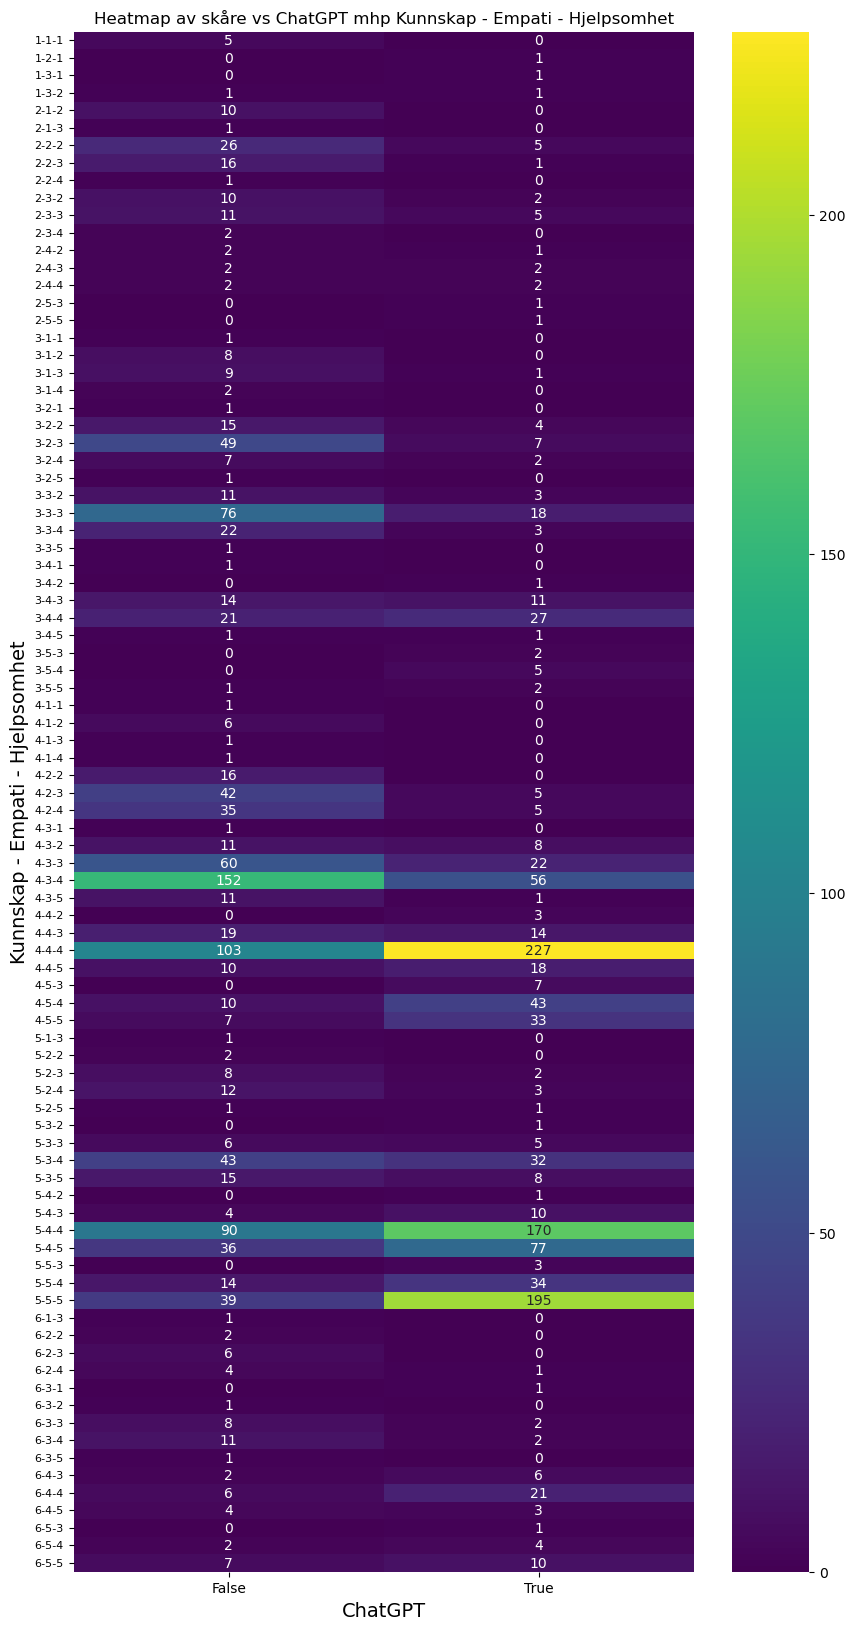

In [45]:
# A heatmap to illustrate the effect of chatgpt True or False on the structure of the sorted_table across items

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the table
pivot_table = sorted_table.pivot_table(values='counts', index=items, columns='chatgpt', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 20))  # Increase figure size
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='viridis', yticklabels=True)

figtitle = f'Heatmap av skåre vs ChatGPT mhp {items[0].capitalize()} - {items[1].capitalize()} - {items[2].capitalize()}'
plt.title(figtitle)
plt.yticks(fontsize=8)  # Decrease y-tick label font size
plt.ylabel(f'{items[0].capitalize()} - {items[1].capitalize()} - {items[2].capitalize()}', fontsize=14)
plt.xlabel(f'ChatGPT', fontsize=14)

plt.show()

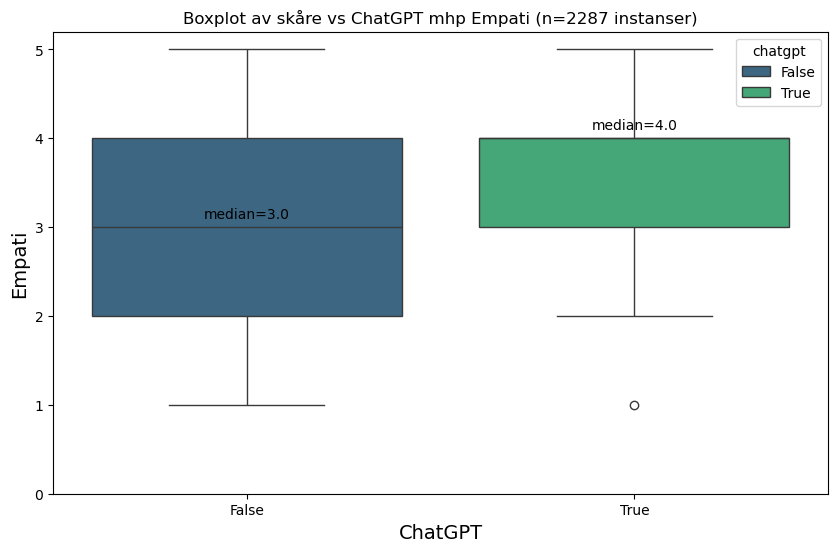

In [46]:
# Plot score distribution on 'empati' grouped by 'chatgpt'

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the boxplot
plt.figure(figsize=(10, 6))  # Increase figure size
sns.boxplot(data=sorted_table, x='chatgpt', y='empati', hue='chatgpt', palette='viridis')

# Integer ticks on y-axis
plt.yticks(np.arange(0, 6, 1))

figtitle = f'Boxplot av skåre vs ChatGPT mhp Empati (n={len(df1)} instanser)'
plt.title(figtitle)
plt.ylabel('Empati', fontsize=14)
plt.xlabel('ChatGPT', fontsize=14)

# Add median values across all instances for each chatgpt group in the legend text
medians = sorted_table.groupby(['chatgpt'])['empati'].median()
median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick, label in zip(pos, plt.gca().get_xticklabels()):
    plt.text(pos[tick], medians.iloc[tick] + 0.1, f'median={median_labels[tick]}', 
             horizontalalignment='center', size=10, color='black', weight='normal')

plt.show()

In [47]:
df1['empati'].value_counts()

empati
4    912
3    625
5    421
2    281
1     48
Name: count, dtype: int64

In [48]:
df1['hjelpsomhet'].value_counts()

hjelpsomhet
4    1177
5     485
3     461
2     151
1      13
Name: count, dtype: int64

In [49]:
df.groupby('chatgpt')['kunnskap'].mean()

chatgpt
False    3.955729
True     4.438368
Name: kunnskap, dtype: float64

In [50]:
df.groupby('chatgpt')['kunnskap'].std()

chatgpt
False    1.000757
True     0.799448
Name: kunnskap, dtype: float64

In [51]:
len(df)

2304

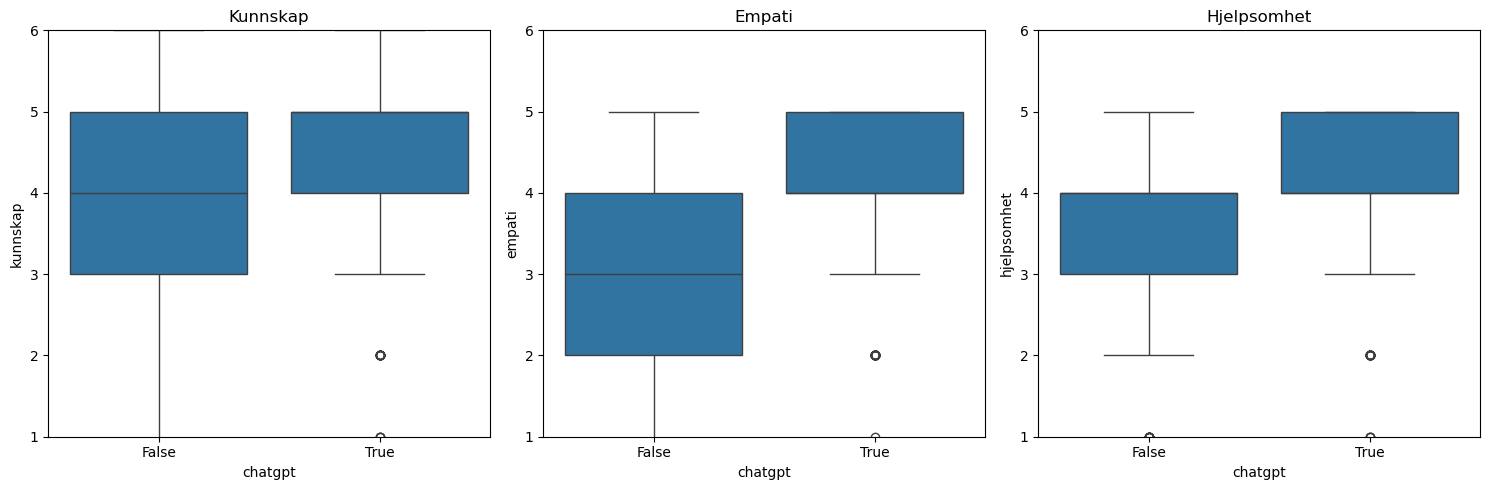

In [52]:
# Make box plots to compare the GPT and human responses for `kunnskap', 'empati` and 'hjelpsomhet'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='chatgpt', y='kunnskap', data=df, ax=ax[0])
ax[0].set_title('Kunnskap')

sns.boxplot(x='chatgpt', y='empati', data=df, ax=ax[1])
ax[1].set_title('Empati')

sns.boxplot(x='chatgpt', y='hjelpsomhet', data=df, ax=ax[2])
ax[2].set_title('Hjelpsomhet')

for a in ax:
    a.set_ylim(1, 6)
plt.tight_layout()  
# Save the plot
#plt.savefig(RESULTS/f'gpt_vs_human_boxplot-{latest_date}.png')




In [53]:
# Create a function that returns the boxplots based on specific column values (e.g., `df['helsepersonell']==True`)

def boxplot_by_column(df, column, criteria, savefig=False):

    # Get a new dataframe where the given column satisfies the given criteria

    df = df[df[column]==criteria]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.boxplot(x='chatgpt', y='kunnskap', data=df, ax=ax[0])
    ax[0].set_title('Kunnskap')

    sns.boxplot(x='chatgpt', y='empati', data=df, ax=ax[1])
    ax[1].set_title('Empati')

    sns.boxplot(x='chatgpt', y='hjelpsomhet', data=df, ax=ax[2])
    ax[2].set_title('Hjelpsomhet')

    # Add title explaining the criteria used and the number of rows in the dataframe
    fig.suptitle(f'Boxplots of GPT vs Human responses for {column}={criteria}\n Number of rows: {len(df)}')
    
    for a in ax:
        a.set_ylim(1, 6)
    plt.tight_layout()
    #if savefig:
    #    plt.savefig(RESULTS/f'gpt_vs_human_boxplot-{column}-{criteria}-{latest_date}.png')
    #plt.show()

----- 2024-02-20 (A.L.) -----

-> 3.1-al-analysis_data_H0_H1.ipynb

In [54]:
df.utdanningsgrad.value_counts()

utdanningsgrad
VGS                  1478
Profesjonsstudium     273
Bachelor              218
PhD                   177
Master                158
Name: count, dtype: int64

In [55]:
df.helsepersonell.value_counts()

helsepersonell
True     2235
False      69
Name: count, dtype: int64

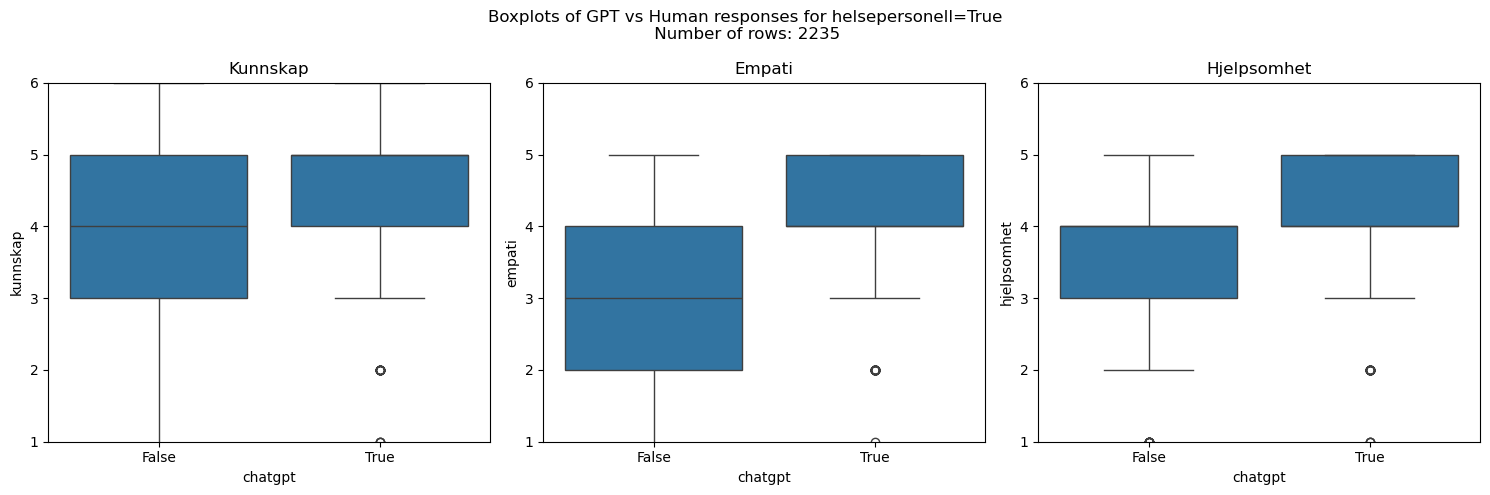

In [56]:
boxplot_by_column(df, 'helsepersonell', True, savefig=True)

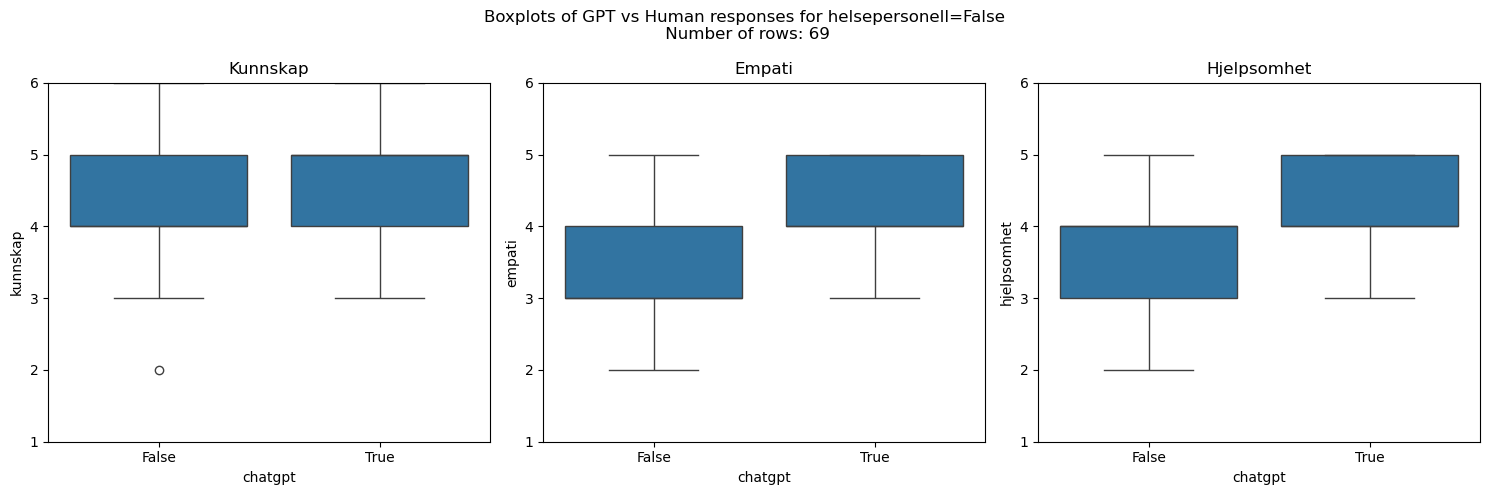

In [57]:
boxplot_by_column(df, 'helsepersonell', False, savefig=True)

In [58]:
df.columns

Index(['vurderingid', 'respondentid', 'svarid', 'kunnskap', 'empati',
       'hjelpsomhet', 'alder', 'utdanningsgrad', 'helsepersonell', 'harlisens',
       'kjønn', 'svartfør', 'fylke', 'dato', 'spørsmålid', 'chatgpt',
       'svartekst', 'tekst'],
      dtype='object')

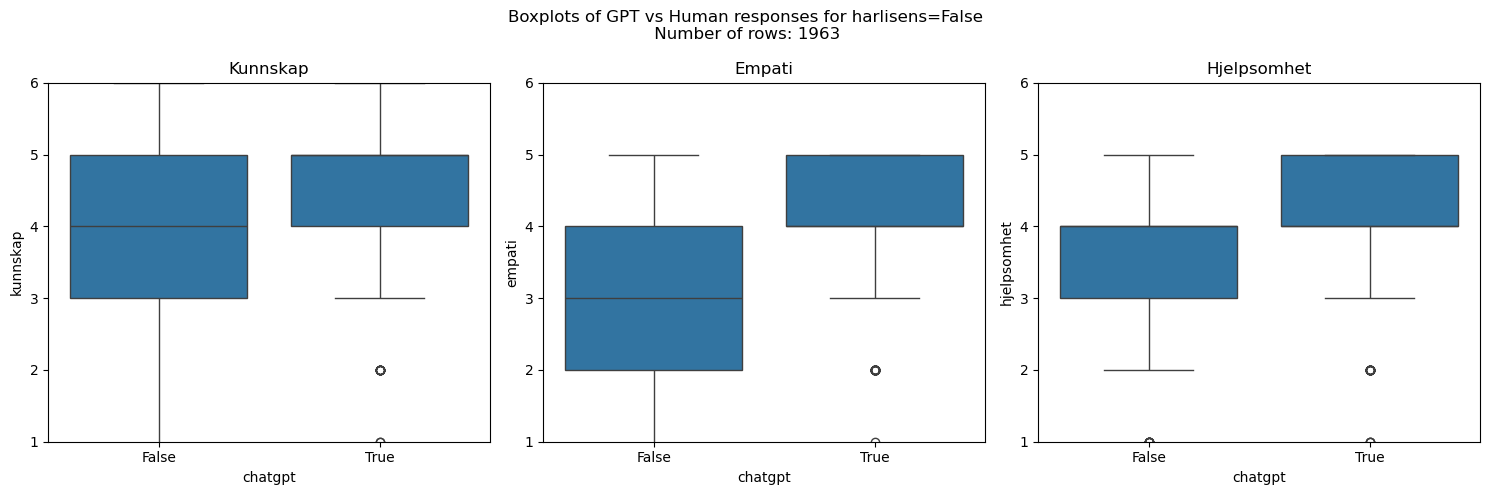

In [59]:
boxplot_by_column(df, 'harlisens', False, savefig=True)

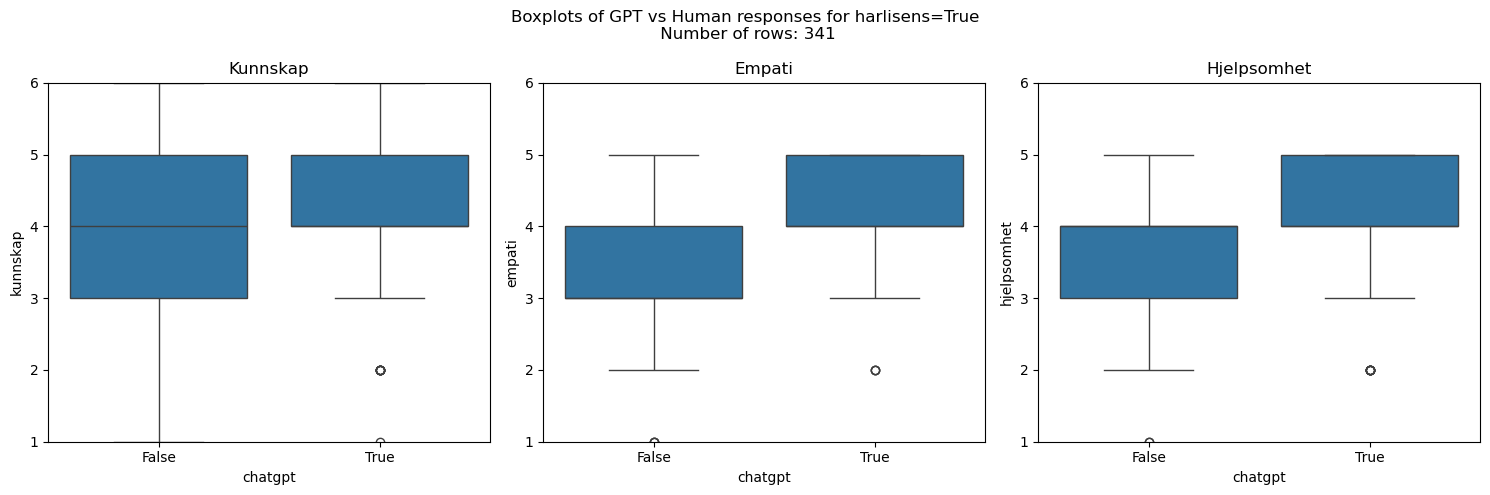

In [60]:
boxplot_by_column(df, 'harlisens', True, savefig=True)

In [61]:
# Function to generate boxplots by gender and age
def boxplot_by_gender_and_age(df):
    for criterion in ['kunnskap', 'empati', 'hjelpsomhet']:
        plt.figure(figsize=(15, 5))
        sns.boxplot(x='kjønn', y=criterion, hue='alder', data=df)
        plt.title(criterion)
        plt.show()

In [62]:

# Function to generate boxplots by education level
def boxplot_and_stats_by_education_level(df):
    for criterion in ['kunnskap', 'empati', 'hjelpsomhet']:
        # Beregn og skriv ut gjennomsnitt og standardavvik for hvert utdanningsnivå
        print(f"Statistikk for {criterion}:")
        for level in df['utdanningsgrad'].unique():
            subset = df[df['utdanningsgrad'] == level]
            mean_val = subset[criterion].mean()
            std_val = subset[criterion].std()
            print(f"Utdanningsgrad: {level}, Gjennomsnitt: {mean_val:.2f}, Standardavvik: {std_val:.2f}")
        
        # Generer boksplottet
        plt.figure(figsize=(15, 5))
        sns.boxplot(x='utdanningsgrad', y=criterion, data=df)
        plt.title(f"Boksplott for {criterion} etter utdanningsnivå")
        plt.xticks(rotation=45)
        plt.show()


Statistikk for kunnskap:
Utdanningsgrad: PhD, Gjennomsnitt: 4.05, Standardavvik: 1.04
Utdanningsgrad: VGS, Gjennomsnitt: 4.23, Standardavvik: 0.91
Utdanningsgrad: Master, Gjennomsnitt: 4.22, Standardavvik: 0.98
Utdanningsgrad: Profesjonsstudium, Gjennomsnitt: 4.19, Standardavvik: 0.98
Utdanningsgrad: Bachelor, Gjennomsnitt: 4.11, Standardavvik: 0.93


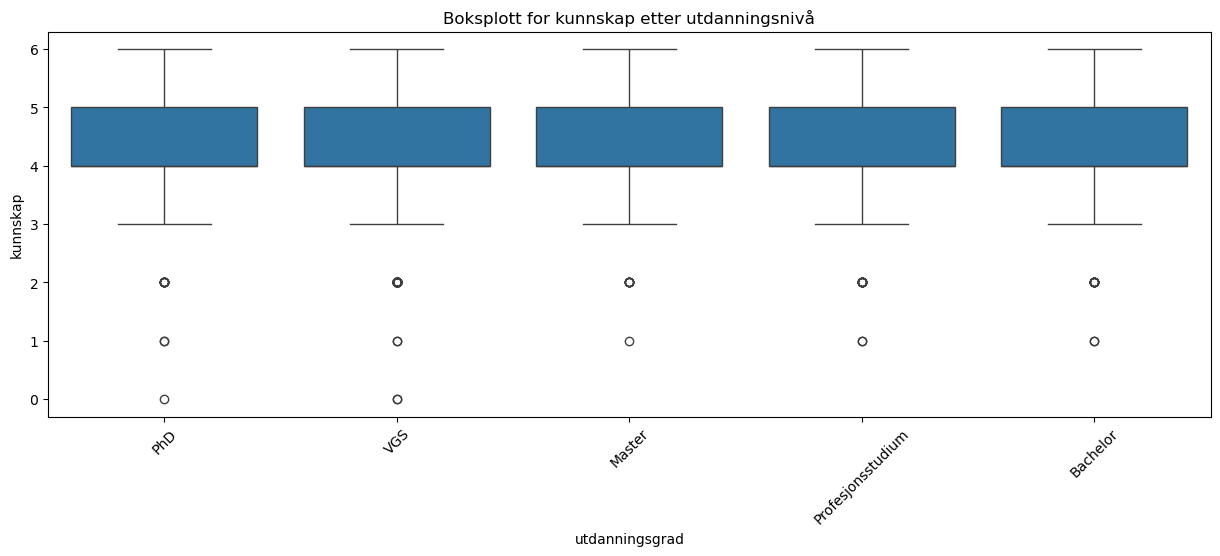

Statistikk for empati:
Utdanningsgrad: PhD, Gjennomsnitt: 3.53, Standardavvik: 0.91
Utdanningsgrad: VGS, Gjennomsnitt: 3.60, Standardavvik: 1.03
Utdanningsgrad: Master, Gjennomsnitt: 3.53, Standardavvik: 1.01
Utdanningsgrad: Profesjonsstudium, Gjennomsnitt: 3.66, Standardavvik: 0.92
Utdanningsgrad: Bachelor, Gjennomsnitt: 3.56, Standardavvik: 1.02


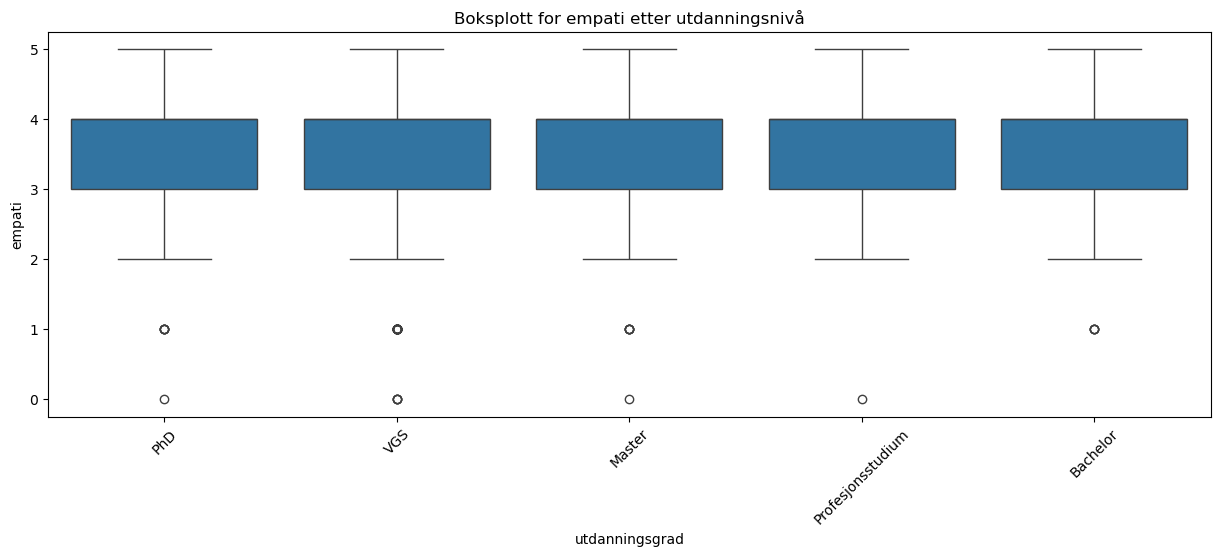

Statistikk for hjelpsomhet:
Utdanningsgrad: PhD, Gjennomsnitt: 3.63, Standardavvik: 0.86
Utdanningsgrad: VGS, Gjennomsnitt: 3.86, Standardavvik: 0.89
Utdanningsgrad: Master, Gjennomsnitt: 3.72, Standardavvik: 0.86
Utdanningsgrad: Profesjonsstudium, Gjennomsnitt: 3.93, Standardavvik: 0.84
Utdanningsgrad: Bachelor, Gjennomsnitt: 3.86, Standardavvik: 0.88


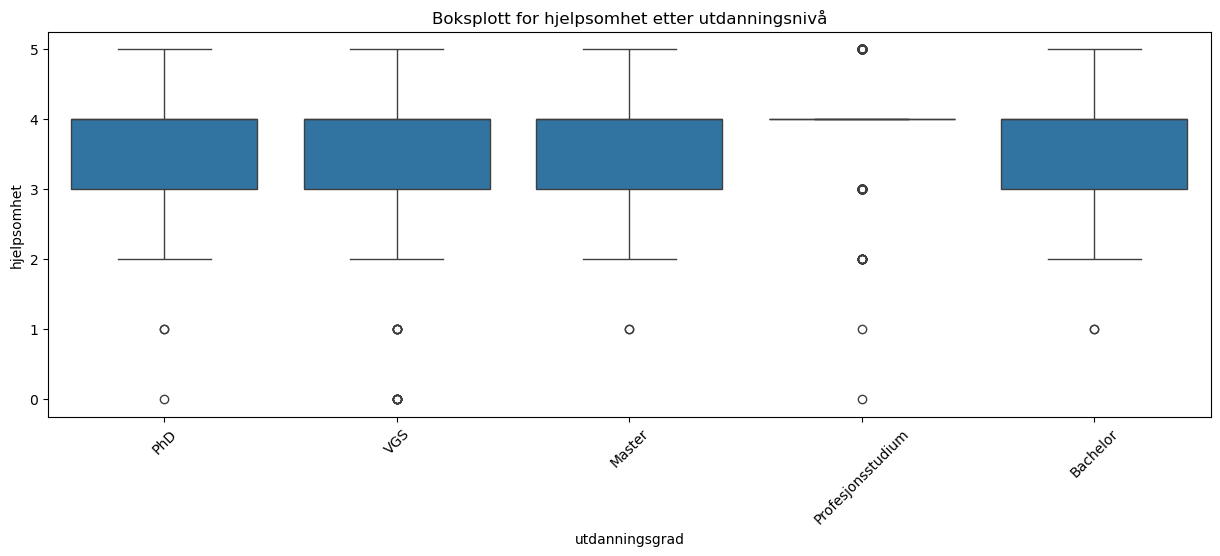

In [63]:
boxplot_and_stats_by_education_level(df)

In [64]:

# Function to generate a correlation heatmap
def correlation_heatmap(df, savefig=False):
    corr = df[['kunnskap', 'empati', 'hjelpsomhet']].corr()
    plt.figure(figsize=(15, 5))  
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    if savefig:
        plt.savefig(RESULTS/f'correlation_heatmap-{latest_date}.png')
    plt.show()

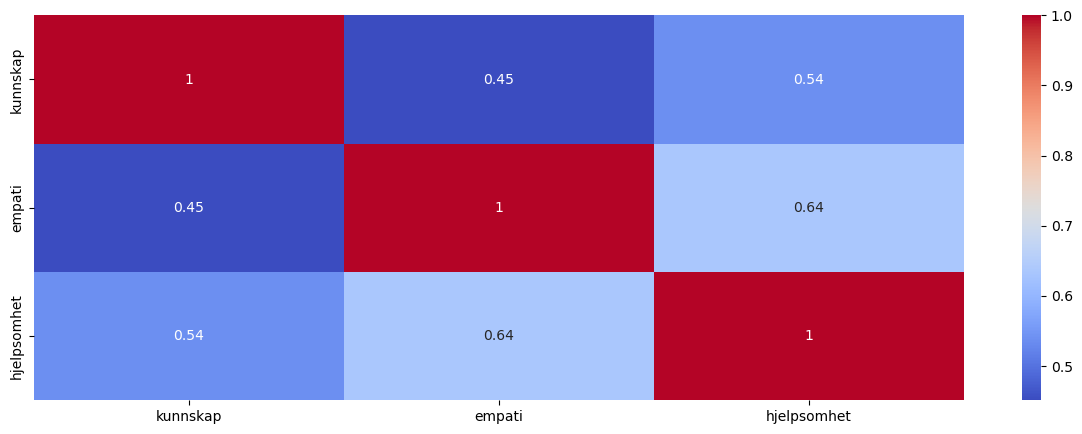

In [65]:
correlation_heatmap(df, savefig=False)

In [66]:
from wordcloud import WordCloud

# Function to generate a wordcloud
def generate_wordcloud(df, high=True):
    if high:
        text = ' '.join(df[df['kunnskap'] > 3]['svartekst'])
    else:
        text = ' '.join(df[df['kunnskap'] <= 3]['svartekst'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(15, 5))  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

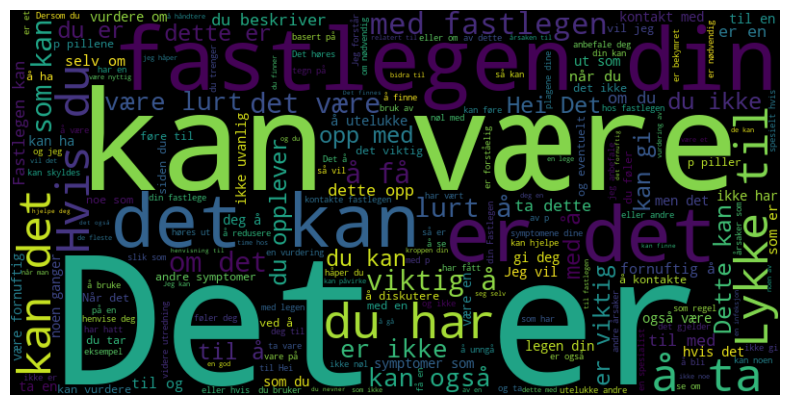

In [67]:
generate_wordcloud(df, high=True)

In [70]:
# Function to generate boxplots by prior response
def boxplot_by_prior_response(df, savefig=False):
    for criterion in ['kunnskap', 'empati', 'hjelpsomhet']:
        plt.figure(figsize=(15, 5))  
        sns.boxplot(x='svartfør', y=criterion, data=df)
        plt.title(criterion)
        #if savefig:
        #     plt.savefig(RESULTS/f'boxplot_by_prior_response-{criterion}-{latest_date}.png')
        plt.show()

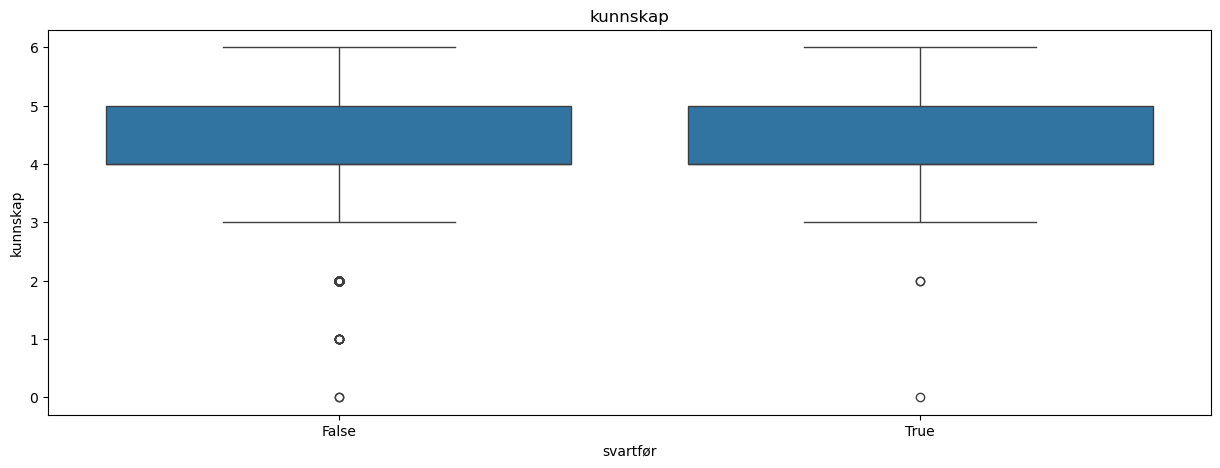

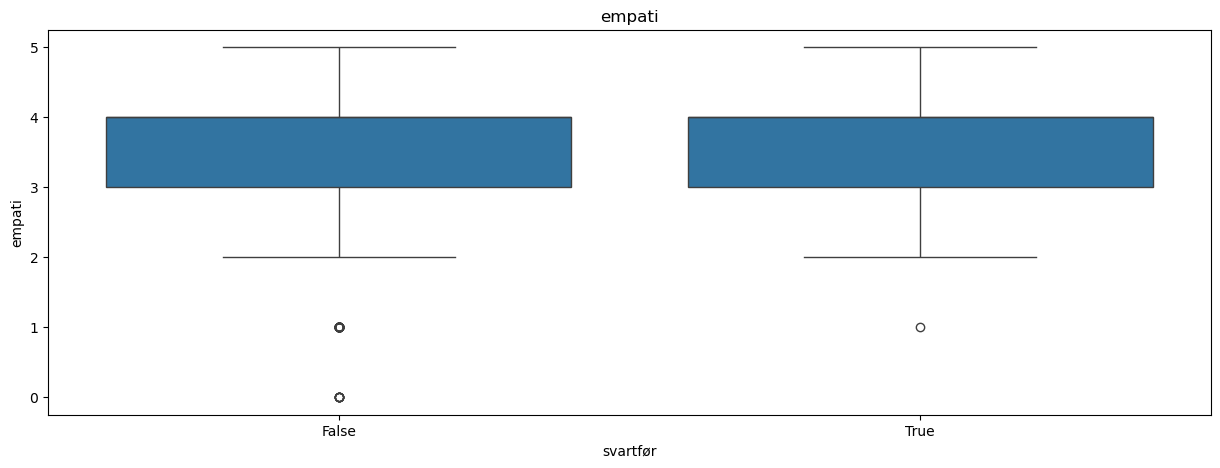

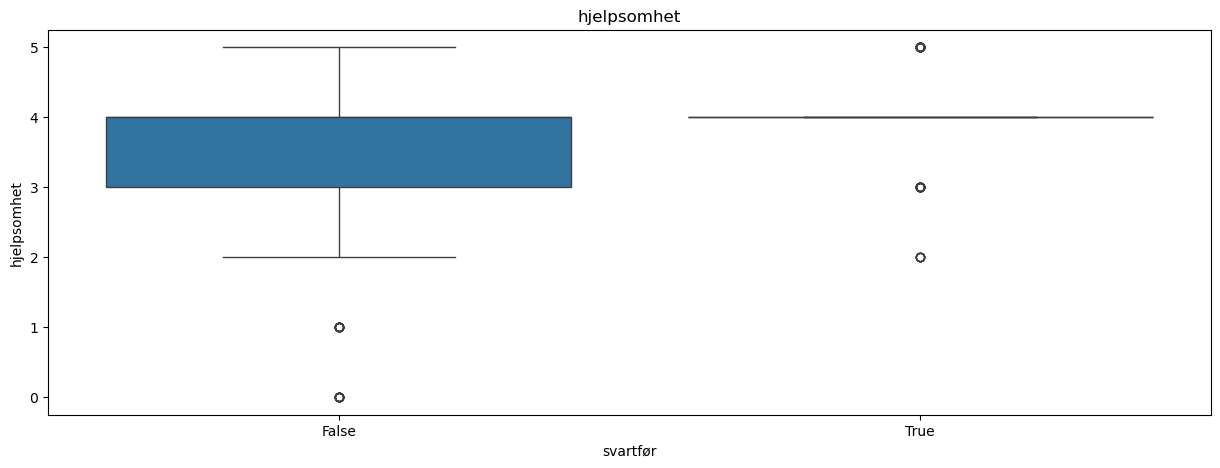

In [71]:
boxplot_by_prior_response(df, savefig=True)